In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import xarray as xr
import os
import pickle

import matplotlib.pyplot as plt
from cmcrameri import cm

In [2]:
datadir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'
savedir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'

df_syracuse = pd.read_csv('%ssyracuse_thermal/Table_2_sub_parameters.csv' % datadir)

#some densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

In [3]:
with open('%s/subduction_tracks.pickle' % datadir, 'rb') as f:
    tracks = pickle.load(f)

In [4]:
#get surface lat/long of subduction zone (for worldview plot)
sub_coords = []
for ind, i in enumerate(tracks):
    sub_coords.append(np.array([tracks[ind]['lon'].iloc[0], tracks[ind]['lat'].iloc[0]]))
sub_coords = np.asarray(sub_coords)   

#define target temp and pressure for serpentinisation
#target_temp = [400, 550]
#target_pressure = [1, 4]




In [5]:
#classify each sub zone region
#to get means and stds of each sub zone region
time_step_perids = []
new_sub_coords = []
sub_results = []
#define target temp and pressure for serpentinisation
target_temp = [100, 700]
target_pressure = [0, 7]
target_sub_chron = [0, 5]
#define arbitary peridotite value (in km)
dummy_value = 0.3

for sub_zone_name in df_syracuse['Name']:    
    #print(sub_zone_name)
    for i in np.arange(target_sub_chron[0],target_sub_chron[1]+1, 1):
        perids = []
        
        for ind, track in enumerate(tracks):
            #print(ind)
            tmp_df = track[(track['sub_zone'] == sub_zone_name)
                         & (track['temp'] > target_temp[0])
                         & (track['temp'] < target_temp[1])
                         & (track['pressure'] > target_pressure[0])
                         & (track['pressure'] < target_pressure[1])
                         & (track['sub_time'] == i)] 
            
            if tmp_df.empty is False:
                #change to dummy values for comparison
                perid_values = tmp_df['peridotite'].values #dummy_value
                try:
                    perid_volume = (perid_values * tmp_df['slab_section_length'] * tmp_df['sub_length']).sum()
                except:
                    #just assume 1 km 'length' of slab for initial
                    perid_volume = (1 * perid_values * tmp_df['sub_length']).sum()
                perids.append(perid_volume)
                new_sub_coords.append(sub_coords[ind])
        time_step_perids.append(np.nansum(perids))

#change to array and reshape
time_step_perids = np.asarray(time_step_perids, dtype=object)
time_step_perids = np.reshape(time_step_perids, (56,6))
summed_sub_perids = np.nansum(time_step_perids, axis=1)
#to sum totals instead

In [6]:
#get ordered list of sub zone contributions
sorted_sub_zone = [x for _,x in sorted(zip(summed_sub_perids,df_syracuse['Name']))]
sorted_totals = np.sort(summed_sub_perids)
for i,j in zip(sorted_sub_zone, sorted_totals):
    print(i,j)

C_Chile 0.0
C_Chile_gap 0.0
C_Honshu 0.0
Calabria 0.0
NC_Chile 0.0
N_Antilles 0.0
N_Chile 0.0
W_Aleut 0.0
Kermadec 2266.417259101922
North_Cascadia 6599.561410742059
Izu 11213.617242782875
S_Kurile 24077.63437114659
N_Honshu 26732.36072520205
Nicaragua 27785.232997177336
New_Zealand 31451.803852978075
Bonin 32319.939053175287
Bali_Lombok 33151.25885872496
N_Kurile 39148.89598952719
C_Sumatra 47483.64967427902
E_Aleut 47561.40561100634
S_Vanuatu 48657.015016389094
N_Marianas 59691.84114110429
Alaska_Peninsula 60306.458345615596
Colombia_Ecuador 65172.67331140906
S_Sumatra 71050.28785107196
C_Peru_gap 72356.80041740793
Mexico 75150.78508236764
Hokkaido 75316.25508494608
GuatElSal 88927.99229785136
Kamchatka 89816.75694720546
Java 93293.72588969527
Costa_Rica 96961.864078535
Nankai 98369.77882110502
W_Banda_Sea 98602.7664339542
S_Chile 99735.33361182068
Solomon 108719.03909534197
Kyushu 115715.310420804
C_Aleut 122493.74089481731
S_Antilles 126786.93229332799
Central_Cascadia 127604.18530

In [7]:
#convert to H2
H2 = time_step_perids*perid_density_kg_km3*10e-2

np.sum(H2)


2.1122486146062694e+18

In [8]:
pressure_range = np.linspace(0,7,20)
temp_range = np.linspace(100,700,20)


pressure_steps = []
temp_steps = []
variables = []
for ind, (i,j) in enumerate(zip(temp_range, pressure_range)):
    if ind == len(temp_range)-1:
        
        break
    else:
        
        start_pressure = pressure_range[ind]
        final_pressure = pressure_range[ind+1]
        pressure_steps.append(([start_pressure, final_pressure]))

        start_temp = temp_range[ind]
        final_temp = temp_range[ind+1]
        temp_steps.append(([start_temp, final_temp]))
pressure_steps = np.asarray(pressure_steps)
temp_steps = np.asarray(temp_steps)

In [9]:
#make PT stats
#get stats for matrix

total_peridotite = []
conditions = []
sub_segment_length = []
#define arbitary peridotite value (in km)
dummy_value = 0.3

#loop through our conditions
for ind, T_range in enumerate(temp_steps):
    for ind2, rho_range in enumerate(pressure_steps):

        #define our target conditions
        target_temp = T_range
        target_pressure = rho_range
        conditions.append([T_range, rho_range])
        
        #arrays to store tmp results
        tmp_perid = []
        tmp_sub_length = []
        #loop through tracks
        for ind3, track in enumerate(tracks):
            tmp_df =  track[(track['temp'] > target_temp[0])
                          & (track['temp'] < target_temp[1])
                          & (track['pressure'] > target_pressure[0])
                          & (track['pressure'] < target_pressure[1])]
            if tmp_df.empty is False:
                #change to dummy values for comparison
                perid_values = tmp_df['peridotite'].values #dummy_value
                #because the shallowest sub point has length of 'nan' we have to check
                try:
                    perid_volume = (perid_values * tmp_df['slab_section_length'] * tmp_df['sub_length']).sum()
                except:
                    #just assume 1 km 'length' of slab for initial
                    perid_volume = (1 * perid_values * tmp_df['sub_length']).sum()
                tmp_perid.append(perid_volume)
            else:
                continue
        total_peridotite.append(np.sum(tmp_perid))
#conver to array
conditions = np.asarray(conditions)
total_peridotite = np.asarray(total_peridotite)

In [10]:
y, x = np.meshgrid(pressure_steps[:,0], temp_steps[:,0])
#h2_reshape = np.reshape(total_h2, np.shape(y))
perid_reshape = np.reshape(total_peridotite, np.shape(y))

/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(0.5, 0.98, 'modelled RAP')

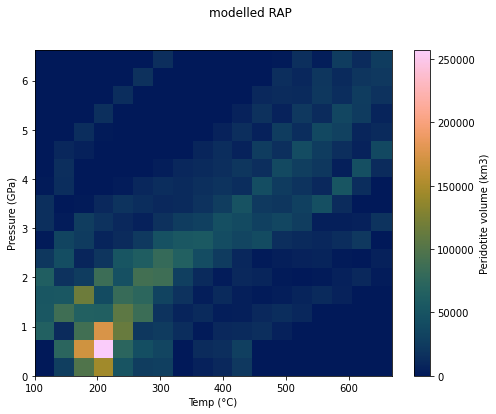

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))
c = ax.pcolor(x, y, perid_reshape, zorder=0, cmap=cm.batlow)
ax.set_ylabel('Pressure (GPa)')
ax.set_xlabel('Temp (°C)')
cbar = fig.colorbar(c, ax=ax)
cbar.set_label('Peridotite volume (km3)')
fig.suptitle('modelled RAP')  

In [12]:
#save results out
df_results = pd.DataFrame({'total_peridotite':total_peridotite})
df_results.to_csv('%sPT_results_20210217.csv' % savedir)